In [1]:
import convex_return_mapping as crm # there is a conflict in the oder of imported modules

from mpi4py import MPI

import plasticity_framework as pf
# import sys
# sys.path.append("../")
# import fenicsx_support as fs

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_dsiplacement(points_on_proc, results):
    if len(points_on_proc) > 0:
        plt.plot(results[:, 0], results[:, 1], "-o")
        plt.xlabel("Displacement of inner boundary")
        plt.ylabel(r"Applied pressure $q/q_{lim}$")
        plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")

In [3]:
Pa_dim = 70e3
E = 70e3 / Pa_dim #[-]
nu = 0.3 #[-]

sig0 = 250 / Pa_dim #[-]
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

vonMises = crm.vonMises(sig0, H)
material_vM = crm.Material(crm.IsotropicElasticity(E, nu), vonMises)
alpha = 0.08
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

alphas = [0, 0.01, 0.05, 0.08]

## Standard plasticity with interpolation

In [5]:
results_list = []
for alpha in alphas:
    DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
    material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
    plasticity = pf.StandardDPPlasticity(material_DP, mesh_name="thick_cylinder_coarse.msh")
    _, results = plasticity.solve()
    results_list.append(results)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 1.2147131367345928e-17, 1.3641252840579853e-13
u 0.0009941219182568394 0.0 0.01196860050336559
rank#0: Time (mean return mapping) = 0.056 (s)

nRes0 , 3.688449012039698e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 5.307352153800226e-18, 1.438911622873507e-13
u 0.0014059006994499425 0.0 0.01692615715448523
rank#0: Time (mean return mapping) = 0.049 (s)

nRes0 , 2.830246470722443e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 4.262305546269069e-18, 1.5059838746768517e-13
u 0.0017218696713369305 0.0 0.020730224167323872
rank#0: Time (mean return mapping) = 0.034 (s)

nRes0 , 2.3860081462258555e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 3.626615748929017e-18, 1.5199511177971175e-13
u 0.001988243836511538 0.0 0.02393720100673146
rank#0: Time (mean return mapping) = 0.033 (s)

nRes0 , 2.10211537593027e-05 
 Increment: 5, load = 0.000567390898726805

Text(0.5, 0.98, 'Standard plasticity with interpolation - Drucker-Prager')

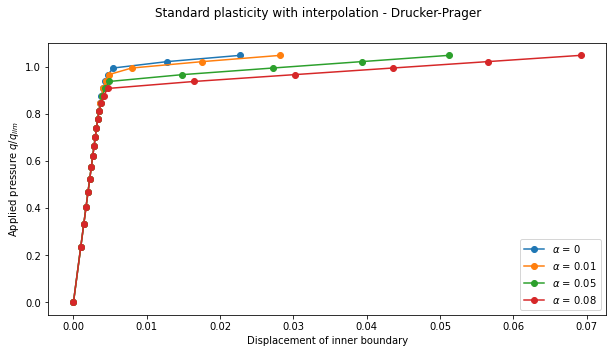

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, alpha in enumerate(alphas):
    ax.plot(results_list[i][:, 0], results_list[i][:, 1], "-o", label=r'$\alpha$ = ' + str(alpha))
    ax.set_xlabel("Displacement of inner boundary")
    ax.set_ylabel(r"Applied pressure $q/q_{lim}$")
    ax.legend()
fig.suptitle('Standard plasticity with interpolation - Drucker-Prager')

Text(0.5, 0.98, 'Standard plasticity with interpolation - Drucker-Prager')

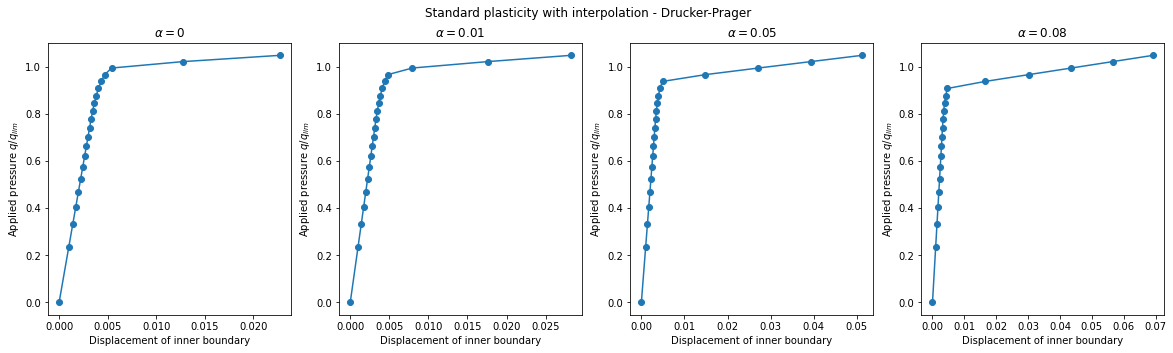

In [9]:
fig, ax = plt.subplots(1, len(alphas), figsize=(20, 5))
for i, alpha in enumerate(alphas):
    ax[i].set_title(r'$\alpha = $' + str(alpha))
    ax[i].plot(results_list[i][:, 0], results_list[i][:, 1], "-o")
    ax[i].set_xlabel("Displacement of inner boundary")
    ax[i].set_ylabel(r"Applied pressure $q/q_{lim}$")
    
fig.suptitle('Standard plasticity with interpolation - Drucker-Prager')

In [6]:
results_list = []
for alpha in alphas:
    DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
    material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
    plasticity = pf.StandardDPPlasticity(material_DP, mesh_name="thick_cylinder_coarse.msh")
    _, results = plasticity.solve(Nincr=50)
    results_list.append(results)



nRes0 , 5.631829071274041e-05 
 Increment: 1, load = 0.00016048238082930143
    Residual: 8.022335968840073e-18, 1.4244636808597686e-13
u 0.0006287379067174682 0.0 0.007569607599054604
rank#0: Time (mean return mapping) = 0.045 (s)

nRes0 , 2.3327799822886153e-05 
 Increment: 2, load = 0.0002269563594907221
    Residual: 3.479155974556057e-18, 1.4914205372864907e-13
u 0.0008891696748571298 0.0 0.010705041728425567
rank#0: Time (mean return mapping) = 0.036 (s)

nRes0 , 1.790005037427202e-05 
 Increment: 3, load = 0.00027796363731596774
    Residual: 2.580284779019396e-18, 1.441495819882202e-13
u 0.0010890059990780474 0.0 0.013110944954922184
rank#0: Time (mean return mapping) = 0.040 (s)

nRes0 , 1.5090440515579392e-05 
 Increment: 4, load = 0.00032096476165860286
    Residual: 2.144874132049329e-18, 1.421346268742094e-13
u 0.0012574758134335823 0.0 0.015139215198109384
rank#0: Time (mean return mapping) = 0.044 (s)

nRes0 , 1.3294944984801497e-05 
 Increment: 5, load = 0.00035884951

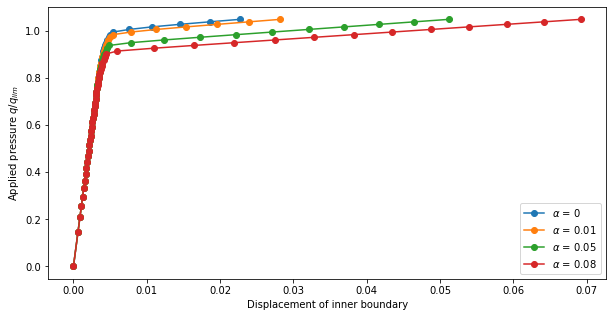

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, alpha in enumerate(alphas):
    ax.plot(results_list[i][:, 0], results_list[i][:, 1], "-o", label=r'$\alpha$ = ' + str(alpha))
    ax.set_xlabel("Displacement of inner boundary")
    ax.set_ylabel(r"Applied pressure $q/q_{lim}$")
    ax.legend()
fig.suptitle('Standard plasticity with interpolation - Drucker-Prager, increments nb. = 50')

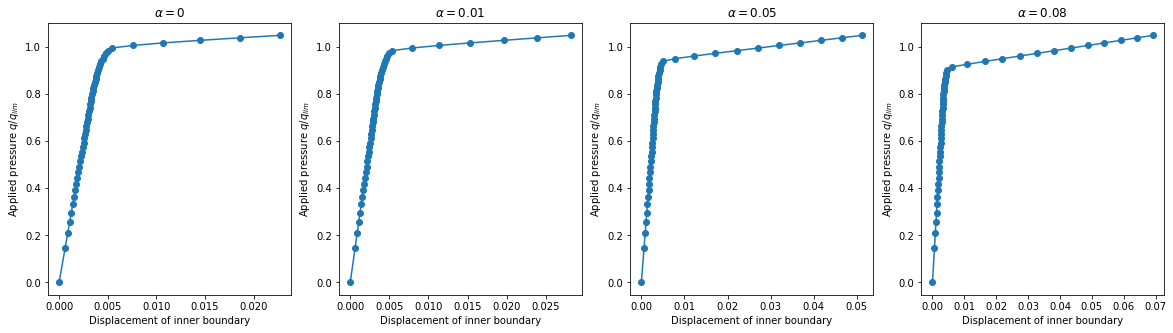

In [11]:
fig, ax = plt.subplots(1, len(alphas), figsize=(20, 5))
for i, alpha in enumerate(alphas):
    ax[i].set_title(r'$\alpha = $' + str(alpha))
    ax[i].plot(results_list[i][:, 0], results_list[i][:, 1], "-o")
    ax[i].set_xlabel("Displacement of inner boundary")
    ax[i].set_ylabel(r"Applied pressure $q/q_{lim}$")

fig.suptitle('Standard plasticity with interpolation - Drucker-Prager, increments nb. = 50')

## Convex plasticity

In [4]:
results_list = []
for alpha in alphas:
    DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
    material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
    plasticity = pf.ConvexPlasticity(material_DP, mesh_name="thick_cylinder_coarse.msh")
    _, results = plasticity.solve()
    results_list.append(results)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 6.333979021162877e-16, 7.113071119563424e-12
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.695 (s)

nRes0 , 3.688449012024125e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 1.871393152572862e-12, 5.0736587288376e-08
    Residual: 1.9385926502878706e-18, 5.2558477668206165e-14
u 0.0014059006994497137 0.0 0.01692615715448422
rank#0: Time (mean return mapping) = 2.440 (s)

nRes0 , 2.8302464707225653e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 2.848770490202401e-12, 1.0065450199024916e-07
    Residual: 1.5085623426991559e-18, 5.3301447711513903e-14
u 0.0017218696713370229 0.0 0.02073022416732207
rank#0: Time (mean return mapping) = 2.408 (s)

nRes0 , 2.3860081462259375e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 3.236322222352133e-12, 1.3563751772898084e-07
    Residual: 1.5991003700101187e-18, 6.70199040

Text(0.5, 0.98, 'Convex plasticity - Drucker-Prager')

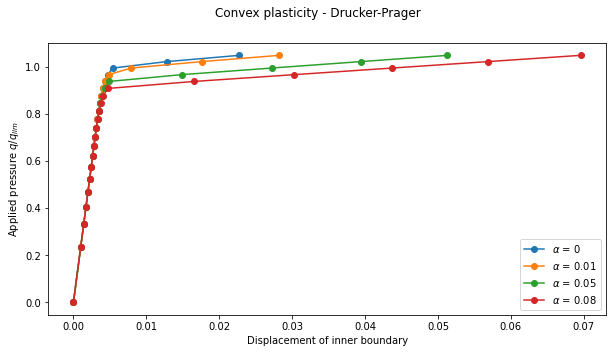

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, alpha in enumerate(alphas):
    ax.plot(results_list[i][:, 0], results_list[i][:, 1], "-o", label=r'$\alpha$ = ' + str(alpha))
    ax.set_xlabel("Displacement of inner boundary")
    ax.set_ylabel(r"Applied pressure $q/q_{lim}$")
    ax.legend()
fig.suptitle('Convex plasticity - Drucker-Prager')

Text(0.5, 0.98, 'Convex plasticity - Drucker-Prager')

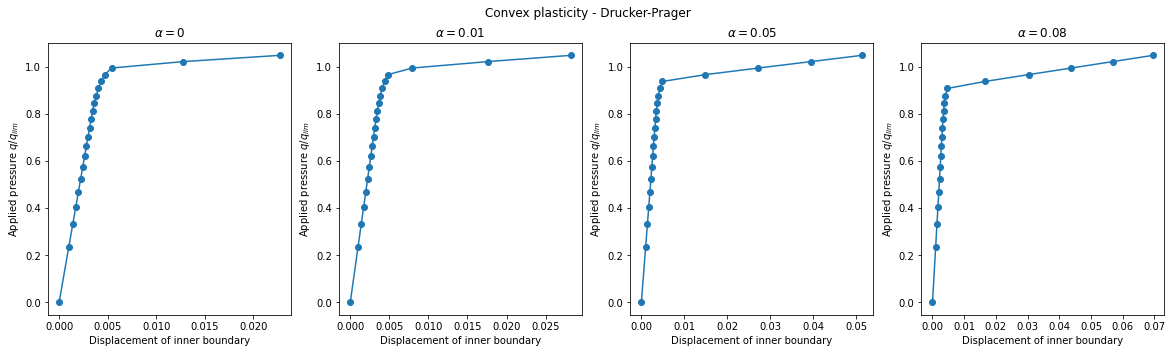

In [6]:
fig, ax = plt.subplots(1, len(alphas), figsize=(20, 5))
for i, alpha in enumerate(alphas):
    ax[i].set_title(r'$\alpha = $' + str(alpha))
    ax[i].plot(results_list[i][:, 0], results_list[i][:, 1], "-o")
    ax[i].set_xlabel("Displacement of inner boundary")
    ax[i].set_ylabel(r"Applied pressure $q/q_{lim}$")

fig.suptitle('Convex plasticity - Drucker-Prager')

## Other calculations



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 1.2147131367345928e-17, 1.3641252840579853e-13
u 0.0009941219182568394 0.0 0.01196860050336559
rank#0: Time (mean return mapping) = 1.060 (s)

nRes0 , 3.688449012039698e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 5.307352153800226e-18, 1.438911622873507e-13
u 0.0014059006994499425 0.0 0.01692615715448523
rank#0: Time (mean return mapping) = 0.053 (s)

nRes0 , 2.830246470722443e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 4.262305546269069e-18, 1.5059838746768517e-13
u 0.0017218696713369305 0.0 0.020730224167323872
rank#0: Time (mean return mapping) = 0.042 (s)

nRes0 , 2.3860081462258555e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 3.626615748929017e-18, 1.5199511177971175e-13
u 0.001988243836511538 0.0 0.02393720100673146
rank#0: Time (mean return mapping) = 0.043 (s)

nRes0 , 2.10211537593027e-05 
 Increment: 5, load = 0.000567390898726805

  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



    Residual: 1.0561759683316234e+152, 3644578648436.1455
    Residual: 1.0273980358470374e+152, 3545273758508.4404
    Residual: 1.4418864351496501e+152, 4975561528177.198
    Residual: 1.8080512461266155e+152, 6239097616773.6455
    Residual: nan, nan
u 2.2896522049361834e+153 -1.875519205273222e+153 inf
rank#0: Time (mean return mapping) = 0.039 (s)

nRes0 , nan 
 Increment: 20, load = 0.0011347817974536106
u 2.2896522049361834e+153 -1.875519205273222e+153 inf
rank#0: Time (mean return mapping) = nan (s)

 rank#0: Time (return mapping) = nan (s)
rank#0: Time = 36.788 (s)


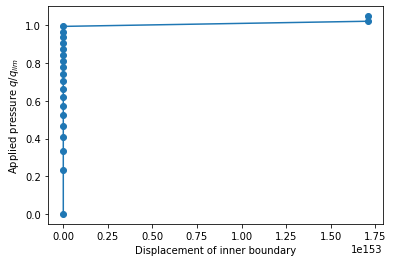

In [8]:
alpha = 0.09
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

plasticity_convex = pf.StandardDPPlasticity(material_DP, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve()
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 3.982304526781411e-05 
 Increment: 1, load = 0.00011347817974536105
    Residual: 6.0518533756436754e-18, 1.519686235681961e-13
u 0.0004445848374289569 0.0 0.005352520864212732
rank#0: Time (mean return mapping) = 1.070 (s)

nRes0 , 1.649524544492496e-05 
 Increment: 2, load = 0.00016048238082930143
    Residual: 2.3621596177109718e-18, 1.4320245343410333e-13
u 0.0006287379067169167 0.0 0.0075696075990546756
rank#0: Time (mean return mapping) = 0.046 (s)

nRes0 , 1.265724700322856e-05 
 Increment: 3, load = 0.00019654997286939883
    Residual: 1.9525524980052527e-18, 1.542636007266986e-13
u 0.000770043526700919 0.0 0.009270838085389031
rank#0: Time (mean return mapping) = 0.040 (s)

nRes0 , 1.067055281965849e-05 
 Increment: 4, load = 0.0002269563594907221
    Residual: 1.5993088502891844e-18, 1.4988059918908401e-13
u 0.0008891696748569534 0.0 0.01070504172842559
rank#0: Time (mean return mapping) = 0.040 (s)

nRes0 , 9.400945754255145e-06 
 Increment: 5, load = 0.00025374492

  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



    Residual: nan, nan
u 1.1031358772216622e+153 -3.77402638605195e+152 3.650093023576446e+153
rank#0: Time (mean return mapping) = 0.043 (s)

nRes0 , nan 
 Increment: 79, load = 0.001008616123699853
u 1.1031358772216622e+153 -3.77402638605195e+152 3.650093023576446e+153
rank#0: Time (mean return mapping) = nan (s)

nRes0 , nan 
 Increment: 80, load = 0.0010149796954942684
u 1.1031358772216622e+153 -3.77402638605195e+152 3.650093023576446e+153
rank#0: Time (mean return mapping) = nan (s)

nRes0 , nan 
 Increment: 81, load = 0.0010213036177082494
u 1.1031358772216622e+153 -3.77402638605195e+152 3.650093023576446e+153
rank#0: Time (mean return mapping) = nan (s)

nRes0 , nan 
 Increment: 82, load = 0.001027588622369029
u 1.1031358772216622e+153 -3.77402638605195e+152 3.650093023576446e+153
rank#0: Time (mean return mapping) = nan (s)

nRes0 , nan 
 Increment: 83, load = 0.0010338354192523098
u 1.1031358772216622e+153 -3.77402638605195e+152 3.650093023576446e+153
rank#0: Time (mean return

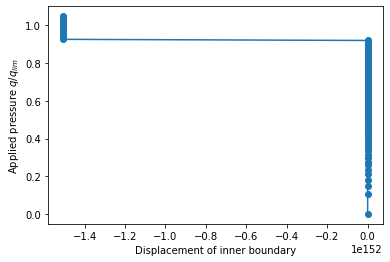

In [15]:
alpha = 0.09
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

plasticity_convex = pf.StandardDPPlasticity(material_DP, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve(Nincr=100)
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 7.348844993282455e-16, 8.252767637722415e-12
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.066 (s)

nRes0 , 3.688449012011788e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 5.767999992518617e-13, 1.5638009292617498e-08
    Residual: 2.7250973274176123e-16, 7.388193027863667e-12
u 0.0014059006994506646 0.0 0.016926157154484492
rank#0: Time (mean return mapping) = 2.035 (s)

nRes0 , 2.8302464707151362e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 9.23891033146887e-13, 3.2643483269266e-08
    Residual: 2.1082307630185835e-18, 7.448929924770417e-14
u 0.0017218696713395404 0.0 0.020730224167321343
rank#0: Time (mean return mapping) = 1.895 (s)

nRes0 , 2.3860081462259046e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 1.0959805000161248e-12, 4.593364451624796e-08
    Residual: 2.2288738481985863e-18, 9.341434360

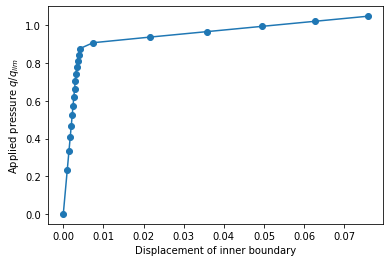

In [9]:
alpha = 0.09
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=3, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve()
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 7.275647783543136e-16, 8.170567024665478e-12
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.297 (s)

nRes0 , 3.688449012019466e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 7.495479954288201e-13, 2.0321495376140077e-08
    Residual: 4.2400729247414494e-16, 1.1495544362750898e-11
u 0.0014059006994515024 0.0 0.016926157154486417
rank#0: Time (mean return mapping) = 1.905 (s)

nRes0 , 2.8302464707057297e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 8.4358127278299e-13, 2.9805929678366165e-08
    Residual: 2.8437378261316908e-18, 1.0047668482464699e-13
u 0.001721869671339855 0.0 0.020730224167323136
rank#0: Time (mean return mapping) = 2.023 (s)

nRes0 , 2.3860081462259578e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 1.0463792916336287e-12, 4.3854808010137254e-08
    Residual: 2.3246871562650067e-18, 9.74299

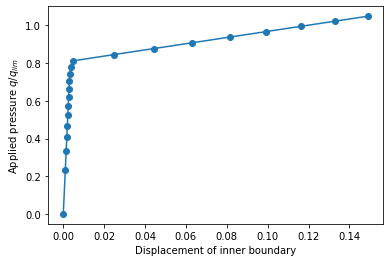

In [10]:
alpha = 0.2
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=3, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve()
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 4.1694012301011375e-16, 4.682245927341221e-12
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.356 (s)

nRes0 , 3.688449012038388e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 1.0700965972675847e-12, 2.9012102208136676e-08
    Residual: 2.245293487177588e-16, 6.087364851322011e-12
u 0.0014059006994502747 0.0 0.016926157154486646
rank#0: Time (mean return mapping) = 2.015 (s)

nRes0 , 2.830246470717948e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 5.83488916369605e-13, 2.0616187402985842e-08
    Residual: 3.926432419392614e-18, 1.3873111264393156e-13
u 0.0017218696713380934 0.0 0.020730224167324552
rank#0: Time (mean return mapping) = 2.096 (s)

nRes0 , 2.3860081462259103e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 8.106985931508632e-13, 3.39771930130747e-08
    Residual: 2.2665045877606397e-17, 9.49914857

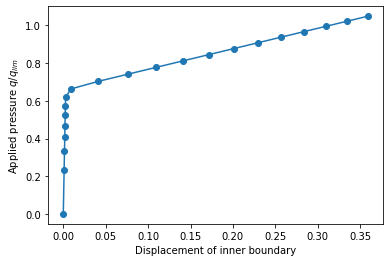

In [11]:
alpha = 0.5
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=3, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve()
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 5.575186777022946e-15, 6.260945910511256e-11
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.407 (s)

nRes0 , 3.688449012039505e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 8.292623536873813e-13, 2.248268448284299e-08
    Residual: 9.184144690225008e-17, 2.4899746913260682e-12
u 0.0014059006994516618 0.0 0.016926157154484003
rank#0: Time (mean return mapping) = 2.046 (s)

nRes0 , 2.830246470723445e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 6.116307756969942e-13, 2.1610512795398137e-08
    Residual: 9.421669355009011e-17, 3.328921863331825e-12
u 0.001721869671337259 0.0 0.020730224167319625
rank#0: Time (mean return mapping) = 1.950 (s)

nRes0 , 2.3860081462259395e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 3.995441559463321e-05, 1.6745297227015328
    Residual: 1.2679748890094675e-05, 0.5314210226042

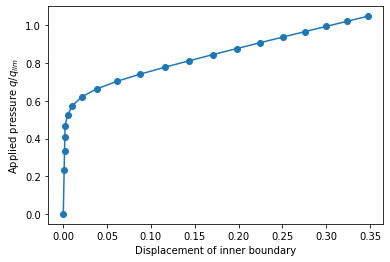

In [12]:
alpha = 1
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=3, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve()
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 3.2146004658454985e-15, 3.6100027578466395e-11
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.433 (s)

nRes0 , 3.6884490119806835e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 1.2429655119774048e-12, 3.369886659514745e-08
    Residual: 1.8070683500550705e-16, 4.8992634686975965e-12
u 0.0014059006994472907 0.0 0.016926157154475416
rank#0: Time (mean return mapping) = 1.957 (s)

nRes0 , 2.8302464707225284e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 4.9126922749437776e-05, 1.7357824930666288
    Residual: 9.787570413451637e-06, 0.3458204264080572
    Residual: 4.415497145726645e-07, 0.015601104679054404
    Residual: 6.924312679962901e-10, 2.446540522739423e-05
    Residual: 1.96988993727485e-15, 6.960135654800271e-11
u 0.0024761236534054 0.0 0.031117325962162247
rank#0: Time (mean return mapping) = 2.071 (s)

nRes0 , 2.38

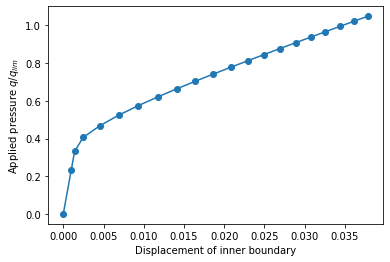

In [13]:
alpha = 1.5
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=3, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve()
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 4.2328212844460094e-16, 4.753466775319153e-12
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.222 (s)

nRes0 , 3.688449012037276e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 3.3393923521289705e-05, 0.9053649220121637
    Residual: 3.6892885650891798e-06, 0.1000227616824623
    Residual: 5.116588467399154e-08, 0.0013871924081642814
    Residual: 8.089983625906965e-12, 2.1933293911628583e-07
    Residual: 1.0341176994846323e-17, 2.8036654325701204e-13
u 0.001786266637407222 0.0 0.022243944093875423
rank#0: Time (mean return mapping) = 1.992 (s)

nRes0 , 2.830246470722518e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 1.9882573979592876e-05, 0.7025032690710207
    Residual: 1.0540242589965738e-06, 0.03724143002738195
    Residual: 2.1240758391181e-09, 7.504914717112452e-05
    Residual: 7.916778400329777e-15, 2.79720458349648

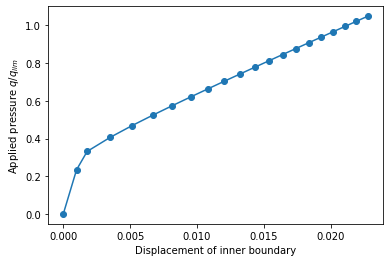

In [14]:
alpha = 2
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=3, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve()
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 3.2820616086917795e-14, 3.6857617563007464e-10
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.955 (s)

nRes0 , 3.6884490122532343e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 3.339392366570064e-05, 0.9053649258743757
    Residual: 3.689290756779409e-06, 0.10002282109698082
    Residual: 5.116599481221555e-08, 0.0013871953941138743
    Residual: 8.090602385851972e-12, 2.193497147167966e-07
    Residual: 1.868482668758029e-16, 5.065767921830626e-12
u 0.0017862666374271296 0.0 0.022243944093706926
rank#0: Time (mean return mapping) = 2.708 (s)

nRes0 , 2.8302464707224078e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 1.9882574481099305e-05, 0.70250328679058
    Residual: 1.0540239706113932e-06, 0.03724141983798175
    Residual: 2.1240493891846504e-09, 7.504821262589532e-05
    Residual: 7.883273535195108e-15, 2.7853664395464

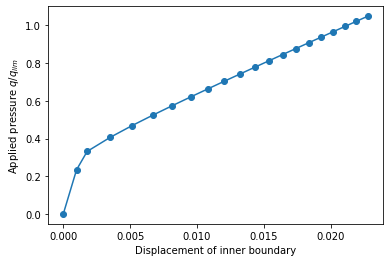

In [16]:
alpha = 2
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=1, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve()
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 5.631829071274041e-05 
 Increment: 1, load = 0.00016048238082930143
    Residual: 1.61639478224892e-14, 2.8701062510820424e-10
u 0.0006287379067173347 0.0 0.00756960759905468
rank#0: Time (mean return mapping) = 2.532 (s)

nRes0 , 2.3327799822838072e-05 
 Increment: 2, load = 0.0002269563594907221
    Residual: 2.2509313971654144e-12, 9.64913714220806e-08
    Residual: 5.353888970951248e-16, 2.295068121130633e-11
u 0.0008891696748601066 0.0 0.010705041728423445
rank#0: Time (mean return mapping) = 2.111 (s)

nRes0 , 1.79000503742402e-05 
 Increment: 3, load = 0.00027796363731596774
    Residual: 7.692420824361344e-13, 4.2974297074780506e-08
    Residual: 7.7954597849103e-17, 4.354993210593795e-12
u 0.0010890059990814153 0.0 0.013110944954920467
rank#0: Time (mean return mapping) = 2.079 (s)

nRes0 , 1.50904405155862e-05 
 Increment: 4, load = 0.00032096476165860286
    Residual: 1.1227150730493719e-05, 0.7439909205365959
    Residual: 5.63652745127324e-07, 0.03735164288578281

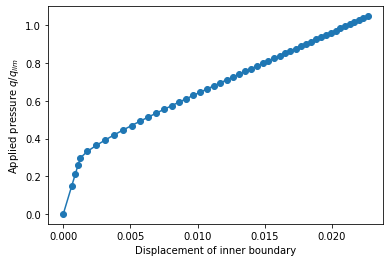

In [17]:
alpha = 2
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=3, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve(Nincr=50)
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 1.2147131367345928e-17, 1.3641252840579853e-13
u 0.0009941219182568394 0.0 0.01196860050336559
rank#0: Time (mean return mapping) = 0.045 (s)

nRes0 , 3.688449012039698e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 5.307352153800226e-18, 1.438911622873507e-13
u 0.0014059006994499425 0.0 0.01692615715448523
rank#0: Time (mean return mapping) = 0.037 (s)

nRes0 , 2.830246470722443e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 4.262305546269069e-18, 1.5059838746768517e-13
u 0.0017218696713369305 0.0 0.020730224167323872
rank#0: Time (mean return mapping) = 0.039 (s)

nRes0 , 2.3860081462258555e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 3.626615748929017e-18, 1.5199511177971175e-13
u 0.001988243836511538 0.0 0.02393720100673146
rank#0: Time (mean return mapping) = 0.053 (s)

nRes0 , 2.10211537593027e-05 
 Increment: 5, load = 0.000567390898726805

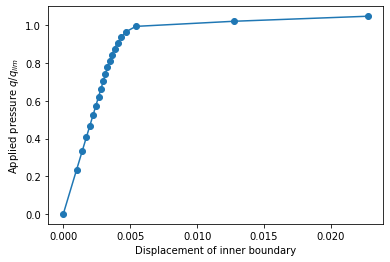

In [11]:
plasticity_vM = pf.StandardPlasticity(material_vM, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_vM = plasticity_vM.solve()
plot_dsiplacement(points_on_proc, results_vM)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 6.333935628505222e-16, 7.1130223895220185e-12
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.706 (s)

nRes0 , 3.688449012024126e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 1.3459707977858566e-12, 3.649151156483582e-08
    Residual: 2.21843119075587e-18, 6.014536688792268e-14
u 0.0014059006994497152 0.0 0.016926157154484225
rank#0: Time (mean return mapping) = 2.439 (s)

nRes0 , 2.8302464707225528e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 2.038308823371975e-12, 7.201877449392601e-08
    Residual: 1.8526243528875766e-18, 6.545805717106354e-14
u 0.0017218696713370207 0.0 0.020730224167322075
rank#0: Time (mean return mapping) = 2.300 (s)

nRes0 , 2.386008146225943e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 2.2240548363629946e-12, 9.321237397621139e-08
    Residual: 1.6254651883164218e-18, 6.81248800

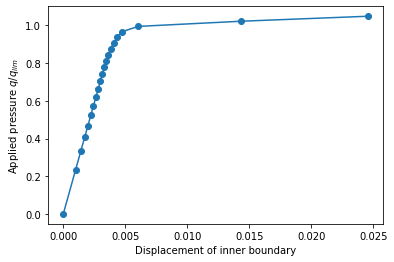

In [4]:
plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=1, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve()
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 7.336513057386459e-16, 8.238918849026237e-12
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.125 (s)

nRes0 , 3.688449012011857e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 7.482606720222056e-13, 2.028659389313527e-08
    Residual: 1.9608018658775316e-18, 5.316060651758925e-14
u 0.0014059006994511618 0.0 0.016926157154483867
rank#0: Time (mean return mapping) = 1.852 (s)

nRes0 , 2.8302464707225494e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 1.0560101025792058e-12, 3.7311595067888596e-08
    Residual: 1.8865002438391583e-18, 6.665498087725e-14
u 0.0017218696713395313 0.0 0.02073022416732137
rank#0: Time (mean return mapping) = 1.975 (s)

nRes0 , 2.386008146225912e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 1.144347249863922e-12, 4.7960743624199387e-08
    Residual: 1.6363321572006187e-18, 6.8580325670

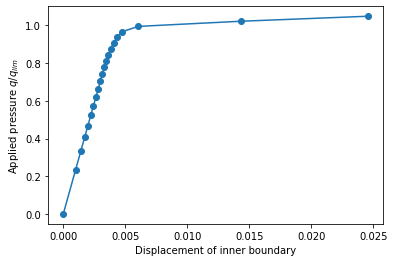

In [5]:
plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=3, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve()
plot_dsiplacement(points_on_proc, results_convex)

In [2]:
np.tan(45*np.pi/180)

NameError: name 'np' is not defined

In [1]:
alpha = np.tan(45*np.pi/180)


NameError: name 'np' is not defined

In [9]:
alpha = 0
vonMises = crm.vonMises(sig0, H)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
points_on_proc, results = plasticity_framework.solve_convex_plasticity_interpolation(sig0, material, 3)

if len(points_on_proc) > 0:
    plot_displacement(results)

NameError: name 'plasticity_framework' is not defined

In [ ]:
alpha = np.tan(60*np.pi/180)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
points_on_proc, results_60 = plasticity_framework.solve_convex_plasticity_interpolation(sig0, material, 3)

if len(points_on_proc) > 0:
    plot_displacement(results_60)


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
du 0.0009941219182566228 0.0 0.011968600503365713
C_tang 1.34615384619914 -1.524293280470659e-08
C_tang relative error 3.047303229610457e-09 5.5956329134935365e-09
    Residual: 2.6180542041075497e-14
p after copy 1.077284341950963e-11 1.6031819583899437e-14 0.0
	rank#0: Time (convex_solving) = 0.00168 (s)
	rank#0: Time (convex_solving_cvxpy) = 0.00083 (s)
	rank#0: Time (differentiation) = 0.00897 (s)
	rank#0: Time (return_mapping) = 2.22369 (s)
	rank#0: Time (differentiation_total) = 1.85694 (s)
	rank#0: Time (convex_solving_total) = 0.34877 (s)

nRes0 , 3.688449011904315e-05 
 Increment: 2, load = 0.00035884951272532715
du 0.0004117787819026752 0.0 0.004957556659562222
C_tang 1.3461538462050198 -0.0693330239491939
C_tang relative error 0.13566368606194748 0.18804585533824864
    Residual: 1.7036461045016703e-05
du 1.4511713045388119e-05 0.0 0.00018160678551417712
C_tang 1.3461538461855647 -0.06602064204261172

KeyboardInterrupt: 


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
du 0.0009941219182566228 0.0 0.011968600503365713
C_tang 1.3461538461793987 -6.619453537503964e-09
C_tang relative error 1.2406089247291672e-09 2.5124766901910807e-09
    Residual: 4.9461226935090735e-16
p after copy 1.1166429427504344e-11 1.4955244927541441e-18 0.0
	rank#0: Time (convex_solving) = 0.00388 (s)
	rank#0: Time (convex_solving_cvxpy) = 0.00177 (s)
	rank#0: Time (differentiation) = 0.00899 (s)
	rank#0: Time (return_mapping) = 2.70807 (s)
	rank#0: Time (differentiation_total) = 1.86172 (s)
	rank#0: Time (convex_solving_total) = 0.80341 (s)

nRes0 , 3.688449012025298e-05 
 Increment: 2, load = 0.00035884951272532715
du 0.0004117787800107665 0.0 0.0049575566444515495
C_tang 1.346153846201634 -2.442654564541547e-08
C_tang relative error 2.3704861674901577e-09 5.290331102118878e-09
    Residual: 6.028929697566723e-13
p after copy 1.9323668424534444e-11 1.9596828429027566e-14 0.0
	rank#0: Time (convex_sol

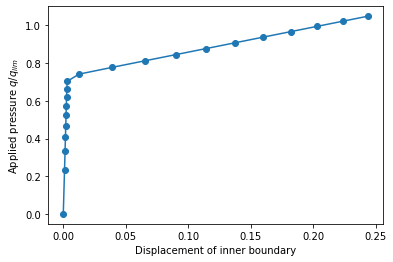

In [ ]:
alpha = np.tan(45*np.pi/180)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
points_on_proc, results_45 = plasticity_framework.solve_convex_plasticity_interpolation(sig0, material, 1)

if len(points_on_proc) > 0:
    plot_displacement(results_45)


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
du 0.0009941219182566228 0.0 0.011968600503365713
C_tang 1.3461538461747102 -1.7442376743512014e-08
C_tang relative error 2.3287691059656234e-09 4.663893389939659e-09
    Residual: 6.193403282196335e-16
p after copy 1.0821069403914617e-11 8.692600919319075e-19 0.0
	rank#0: Time (convex_solving) = 0.00399 (s)
	rank#0: Time (convex_solving_cvxpy) = 0.00182 (s)
	rank#0: Time (differentiation) = 0.00930 (s)
	rank#0: Time (return_mapping) = 2.79329 (s)
	rank#0: Time (differentiation_total) = 1.92437 (s)
	rank#0: Time (convex_solving_total) = 0.82583 (s)

nRes0 , 3.688449012023666e-05 
 Increment: 2, load = 0.00035884951272532715
du 0.00041177877838603094 0.0 0.004957556631973069
C_tang 1.3461538461919713 -3.835465491964918e-08
C_tang relative error 5.5158691520362664e-09 1.0830546256648598e-08
    Residual: 9.850356014957099e-13
p after copy 1.9356347515374237e-11 2.316867220788844e-14 0.0
	rank#0: Time (convex_solv

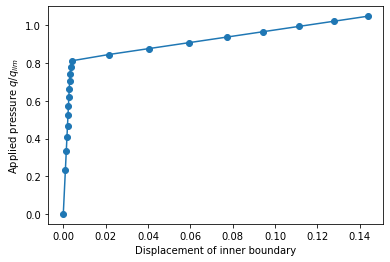

In [ ]:
alpha = np.tan(30*np.pi/180)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
points_on_proc, results_30 = plasticity_framework.solve_convex_plasticity_interpolation(sig0, material, 1)

if len(points_on_proc) > 0:
    plot_displacement(results_30)